In [45]:
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset, DataLoader
import tqdm
import time
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [46]:
cfg = {
    "vocab_size": 50257,
    "emb_dim": 768,
    "context_length":256,
    "n_layers":12,
    "n_heads": 12,
    "drop_rate": 0.2,
    "kqv_bias": False
}

In [47]:
class LayerNorm(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(cfg["emb_dim"]))
        self.shift = nn.Parameter(torch.zeros(cfg["emb_dim"]))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale * norm + self.shift

In [48]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [49]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]), #expansion
            GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )

    def forward(self,x):
        return self.layers(x)        

In [50]:
class MultiHeadAttention(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        assert cfg["emb_dim"] % cfg["n_heads"] == 0 , "embedding dimension must be divisible by number of heads"
    
        self.n_heads = cfg["n_heads"]
        self.head_dim = cfg["emb_dim"] // cfg["n_heads"]

        self.w_key = nn.Linear(cfg["emb_dim"],cfg["emb_dim"],bias=cfg["kqv_bias"])
        self.w_query = nn.Linear(cfg["emb_dim"],cfg["emb_dim"],bias=cfg["kqv_bias"])
        self.w_value = nn.Linear(cfg["emb_dim"],cfg["emb_dim"],bias=cfg["kqv_bias"])
        self.out_proj = nn.Linear(cfg["emb_dim"],cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])
        self.register_buffer("mask",torch.triu(torch.ones(cfg["context_length"],cfg["context_length"]),diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in_emb = x.shape

        keys = self.w_key(x)
        queries = self.w_query(x)
        values = self.w_value(x)

        keys = keys.view(b,num_tokens,self.n_heads,self.head_dim)
        queries = queries.view(b,num_tokens,self.n_heads,self.head_dim)
        values = values.view(b,num_tokens,self.n_heads,self.head_dim)

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attention_score = queries @ keys.transpose(2,3)
        mask_bool = self.mask[:num_tokens, :num_tokens].bool()
        attention_score = attention_score.masked_fill_(mask_bool,-torch.inf)

        attention_weight = torch.softmax(
            attention_score/keys.shape[-1] ** 0.5,
            dim=-1
        )
        attention_weight = self.dropout(attention_weight)
        context_vector_per_head = attention_weight @ values
        context_vectors = context_vector_per_head.transpose(1,2)
        context_vectors = context_vectors.contiguous().view(b,num_tokens,d_in_emb)

        context_vectors = self.out_proj(context_vectors)
        return context_vectors

In [51]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg)
        self.att = MultiHeadAttention(cfg)
        self.norm2 = LayerNorm(cfg)
        self.dropout = nn.Dropout(cfg["drop_rate"])
        self.ff = FeedForward(cfg)

    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout(x)

        x = x + shortcut
        shortcut = x

        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)

        return x + shortcut       

In [52]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])
        self.trf_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg)
        self.out_proj = nn.Linear(cfg["emb_dim"],cfg["vocab_size"])

    def forward(self,in_ids):
        batch_size,num_tokens = in_ids.shape
        token_embedding = self.tok_emb(in_ids)
        pos_embedding = self.pos_emb(torch.arange(num_tokens,device=in_ids.device))
        input_embedding = token_embedding + pos_embedding
        x = self.dropout(input_embedding)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_proj(x)
        return logits      
        

In [53]:
# --- Data Preparation ---
def load_text_data(file_path="the-verdict.txt", url=None):
    if url and not os.path.exists(file_path):
        print(f"Downloading {file_path} from {url}...")
        with urllib.request.urlopen(url) as response:
            text_data_bytes = response.read()
            text_data = text_data_bytes.decode('utf-8')
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
        print("Download complete.")
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    return text_data

In [54]:
class GPTDataset(Dataset):
    def __init__(self,text,tokenizer,context_length,stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
        
        for i in range(0,len(token_ids)-context_length,stride):
            input_chunk = token_ids[i:i+context_length]
            target_chunk = token_ids[i+1:i+context_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)
        
    def __getitem__(self,idx):
        return self.input_ids[idx],self.target_ids[idx]

In [55]:
def create_dataloader(text,tokenizer,context_length,stride,batch_size=4,shuffle=True,drop_last=True,num_workers=0):

    dataset = GPTDataset(text,tokenizer,context_length,stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )       
    return dataloader

In [56]:
def text_to_token_ids(text,tokenizer):
    ids = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
    return torch.tensor(ids).unsqueeze(0)

In [57]:
def token_ids_to_text(ids,tokenizer):
    ids = ids.squeeze(0).tolist()
    text = tokenizer.decode(ids)
    return text

In [58]:
def generate_text_simple(model,ids,max_new_tokens,context_length):
    for _ in range(max_new_tokens):
        ids_last_context_window = ids[:,-context_length:]
        with torch.no_grad():
            logits = model(ids_last_context_window)
        logits = logits[:,-1,:]
        proba = torch.softmax(logits,dim=-1)
        next_ids = torch.argmax(proba,dim=-1,keepdim=True)
        ids = torch.cat((ids,next_ids),dim=1)
    return ids

In [59]:
def generate(model,ids,max_new_tokens,context_length,temperature=1.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens):
        ids_last_context_window = ids[:,-context_length:]
        with torch.no_grad():
            logits = model(ids_last_context_window) #[2,4,50257]
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits,_ = torch.topk(logits,top_k)
            min_value = top_logits[:,-1]
            logits = torch.where(logits < min_value,torch.tensor(float("-inf")).to(logits.device),logits)

        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits,dim=-1)
            next_ids = torch.multinomial(probas,num_samples=1)
        else:
            next_ids = torch.argmax(logits,dim=-1,keepdim=True)
            
        if next_ids == eos_id:
            break

        ids = torch.cat((ids,next_ids),dim=1)

    return ids

In [60]:
def calculate_batch_loss(input_batch,target_batch,model,device):
    input_batch,target_batch = input_batch.to(device),target_batch.to(device)
    logits = model(input_batch)
    loss = nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
    return loss

In [61]:
def calculate_loader_loss(dataloader,model,device,num_batches=None):
    total_loss = 0
    if len(dataloader) == 0: return float("nan")
    if num_batches is None: num_batches = len(dataloader)
    else: num_batches = min(len(dataloader),num_batches)
    for i, (input_batch,target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calculate_batch_loss(input_batch,target_batch,model,device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches        

In [62]:
def evaluate_model(train_loader,val_loader,model,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loader_loss(train_loader,model,device,num_batches=eval_iter)
        val_loss = calculate_loader_loss(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss,val_loss    

In [63]:
def generate_and_print_sample(model,tokenizer,start_context,context_size,device):
    model.eval()
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(model,encoded,max_new_tokens=20,context_length=context_size,temperature=1.4,top_k=10)
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n",""))
    model.train()    

In [64]:
def plot_losses_matplotlib(epochs_seen, tokens_seen, train_losses, val_losses, title_suffix=""):
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.plot(tokens_seen, train_losses, label="Training loss")
    ax1.plot(tokens_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Tokens Seen")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()
    ax2.plot(epochs_seen, train_losses, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Epochs")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f"Training and Validation Loss {title_suffix}")
    fig.tight_layout()
    plt.savefig(f"loss-plot{title_suffix.replace(' ', '-')}.pdf") # Optional: save plot
    plt.show()

In [65]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer,context_length):
    train_losses,val_losses,track_token_seen_list,track_epochs_seen_list = [],[],[],[]
    token_seen_total,global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm.tqdm(train_loader,desc=f"Epoch {epoch+1}/{num_epochs}")
        for input_batch,target_batch in pbar:
            optimizer.zero_grad()
            loss = calculate_batch_loss(input_batch,target_batch,model,device)
            loss.backward()
            optimizer.step()
            token_seen_total += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss,val_loss = evaluate_model(train_loader,val_loader,model,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen_list.append(token_seen_total)
                track_epochs_seen_list.append(epoch + (global_step * train_loader.batch_size) / len(train_loader.dataset) ) # Approximate epoch
                pbar.set_postfix_str(f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

        generate_and_print_sample(model,tokenizer,start_context,context_length,device)
        pbar.close()
    return train_losses,val_losses,track_token_seen_list,track_epochs_seen_list

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
text_data = load_text_data()

In [68]:
tokenizer = tiktoken.get_encoding("gpt2")

In [69]:
model = GPTModel(cfg).to(device)

In [70]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [71]:
train_loader = create_dataloader(text=train_data,
                                 tokenizer=tokenizer,
                                 context_length=cfg["context_length"],
                                 stride=cfg["context_length"],
                                 shuffle=True,
                                 drop_last=True)
validation_loader = create_dataloader(text=val_data,
                                 tokenizer=tokenizer,
                                 context_length=cfg["context_length"],
                                 stride=cfg["context_length"],
                                 shuffle=False,
                                 drop_last=False)

In [72]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

In [73]:
# Calculate initial losses
with torch.no_grad():
    initial_train_loss = calculate_loader_loss(train_loader, model, device)
    initial_val_loss = calculate_loader_loss(validation_loader, model, device)
print(f"Initial Train Loss: {initial_train_loss:.3f}")
print(f"Initial Val Loss: {initial_val_loss:.3f}")

Initial Train Loss: 10.970
Initial Val Loss: 10.973


In [74]:
num_epochs=6
eval_freq = len(train_loader) // 2
if eval_freq == 0 : eval_freq = 1
eval_iter = 5
start_context=start_context = "Every effort moves you"

In [75]:
print("Starting Tranining .....")
train_start_time = time.time()

all_train_losses,all_validation_losses,all_token_seen_list,all_epochs_seen_list = train_model_simple(model,train_loader,validation_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer,cfg["context_length"])

train_end_time = time.time()
print(f"Training complete in {((train_end_time - train_start_time)/60):.2f}")

Starting Tranining .....


Epoch 1/6: 100%|█| 4/4 [00:20<00:00,  5.08s/it, Train Loss: 8.894, Val Loss: 9.1


Every effort moves you, of, my. the. the the..


Epoch 2/6: 100%|█| 4/4 [00:19<00:00,  4.79s/it, Train Loss: 7.490, Val Loss: 7.8


Every effort moves you the. I-- the the and the, I the I the the the the and,.


Epoch 3/6: 100%|█| 4/4 [00:21<00:00,  5.37s/it, Train Loss: 6.403, Val Loss: 6.9


Every effort moves you. he-- his, in,, to of the was of.


Epoch 4/6: 100%|█| 4/4 [00:20<00:00,  5.20s/it, Train Loss: 5.861, Val Loss: 6.5


Every effort moves you a a."" the and to the a to I I, and of it the- the


Epoch 5/6: 100%|█| 4/4 [00:20<00:00,  5.21s/it, Train Loss: 5.256, Val Loss: 6.4


Every effort moves you I was that he had was--as was, and the on his of the and I of the


Epoch 6/6: 100%|█| 4/4 [00:20<00:00,  5.20s/it, Train Loss: 4.686, Val Loss: 6.3


Every effort moves you the to the that-, I had a- my's the- of the of Jack- it
Training complete in 2.17


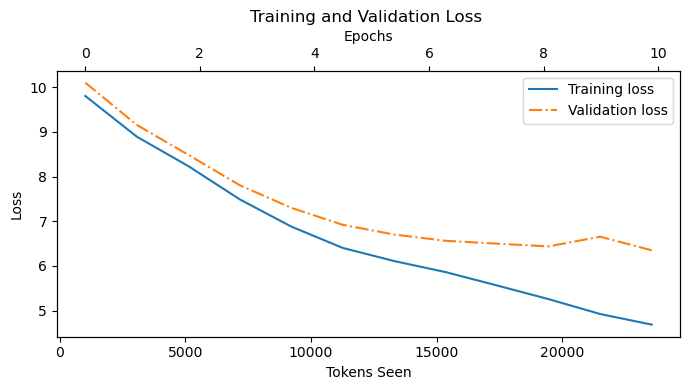

In [76]:
#plot losses
if all_train_losses:
    plot_losses_matplotlib(epochs_seen=all_epochs_seen_list,tokens_seen=all_token_seen_list,train_losses=all_train_losses,val_losses=all_validation_losses)
else:
    print("No losses recorded during training process")

In [77]:
#generate text with train model
model.eval()
final_output_ids = generate(model,
                            ids=text_to_token_ids("hello my name is lochan",tokenizer).to(device),
                            max_new_tokens=10,
                            context_length=cfg["context_length"],
                            temperature=1.4,
                            top_k=10,)
print(token_ids_to_text(final_output_ids,tokenizer))                            

hello my name is lochan to have a that Mrs. Gisburn's


In [78]:
#save the model
model_save_path = "gpt_model.pth"
optimizer_save_path = "optimizer.pth"

torch.save(model.state_dict(),model_save_path)
print(f"model saved successfully to {model_save_path}")

torch.save(optimizer.state_dict(),optimizer_save_path)
print(f"optimizer saved successfully to {optimizer_save_path}")

model saved successfully to gpt_model.pth
optimizer saved successfully to optimizer.pth


In [79]:
#load the model
model = GPTModel(cfg)
model.load_state_dict(torch.load(model_save_path,map_location=device))
model.to(device)
model.eval()
print("model loaded successfully")

/tmp/ipykernel_5481/632782512.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path,map_location=device))


model loaded successfully
